# Work-through of a small tip angle spoke pulse design from scratch

Minghao Zhang

Coded for my own sanity

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.optimize as opt

Load some field maps and inspect

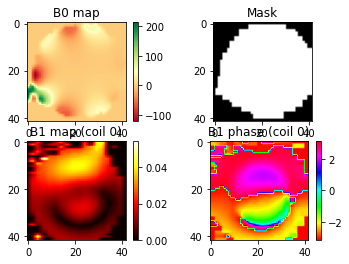

In [ ]:
adj_dict = sio.loadmat('demo-data/phantom-mat/AdjDataUser.mat',simplify_cells=True)['Adj']
b0map = adj_dict['B0']
b1map = adj_dict['S'].reshape(adj_dict['image_m'], adj_dict['image_n'], adj_dict['coils'], adj_dict['slices']).transpose([2,0,1,3])
wmask = adj_dict['W'].astype(bool)
(XX, YY, ZZ) = np.meshgrid(adj_dict['values_m'], adj_dict['values_n'], adj_dict['values_s'])

fig, axs = plt.subplots(2, 2)
im1 = axs[0,0].imshow(b0map, cmap='RdYlGn')
axs[0,0].set_title('B0 map')
plt.colorbar(im1, ax=axs[0,0])
axs[0,1].imshow(wmask, cmap='gray')
axs[0,1].set_title('Mask')
im2 = axs[1,0].imshow(np.abs(b1map[0,:,:,0]), cmap='hot')
axs[1,0].set_title('B1 map (coil 0)')
plt.colorbar(im2, ax=axs[1,0])
im3 = axs[1,1].imshow(np.angle(b1map[0,:,:,0]), cmap='hsv', vmin=-np.pi, vmax=np.pi)
axs[1,1].set_title('B1 phase (coil 0)')
plt.colorbar(im3, ax=axs[1,1])


Subpulse form and gradient trajectory

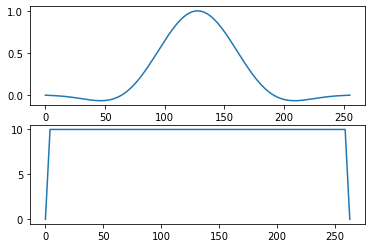

In [ ]:
def sinc_pulse(nt: int, tbw: float) -> np.ndarray:
    t = np.linspace(-tbw/2, tbw/2, nt)
    pulse = np.sinc(t)
    # windowing
    n = np.linspace(-0.5,0.5,nt)
    window = 0.53836+0.46164*np.cos(2*np.pi*n)
    pulse = pulse*window
    return pulse

subpulse = sinc_pulse(256, 4)

def trapz_gradient(nt_plat: int, plat_amp: float, slew_per_step: float,
                    polarity: bool=True) -> np.ndarray:
    plat = np.ones(nt_plat) * plat_amp
    n_ramp = int(np.ceil(plat_amp / slew_per_step))  # no higher than prescribed slew
    ramp = np.linspace(0, plat_amp, n_ramp)
    grad_out = np.concatenate((ramp[:-1], plat, ramp[-2::-1]))
    return grad_out * (1 if polarity else -1)

SLEWLIM = 200000  # mT/m/s
DT = 1e-5  # s
gzflat = 10  # mT/m
subpulselen = 256
grad_z = trapz_gradient(subpulselen, gzflat, SLEWLIM*DT)

fig, ax = plt.subplots(2,1)
ax[0].plot(subpulse)
ax[1].plot(grad_z)


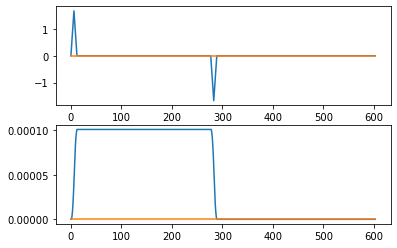

In [ ]:
k_positions = np.array([[0.05, -0.0],
                        [0,0]])  # in cm-1

def spokes_traj(k_positions: np.ndarray, gz_spoke: np.ndarray, 
                slew: float, dt: float=1e-5) -> np.ndarray:
    gamma = 42.57e6  # Hz/T
    
    k_positions = np.concatenate(([[0,0]], k_positions), axis=0)
    k_diff = np.diff(k_positions[::-1], axis=0)  # in cm-1
    g_integral = k_diff * 100 / gamma / dt * 1e3  # in mT/m * step

    # tramp * (tramp*slew) = area
    tramp = np.ceil(np.sqrt(np.abs(g_integral) / (slew * dt))).astype(int) + 1
    tramp = np.max(tramp, axis=1, keepdims=True)  # use the larger in x and y
    
    # (tramp*2) * ramp_top / 2 = area
    ramp_top = g_integral / tramp

    # make the gradient
    g = np.zeros(((2*tramp-1).sum() + gz_spoke.size * (k_positions.shape[0] - 1), 3))
    current_pos = 0
    for i in range(k_positions.shape[0]-1):
        for xy in range(2):
            ramp = np.linspace(0, ramp_top[i, xy], tramp[i][0])
            g[current_pos:current_pos+2*tramp[i][0]-1, xy] = np.concatenate((ramp, ramp[-2::-1]))
        current_pos += 2*tramp[i][0]-1
        g[current_pos:current_pos+gz_spoke.size, 2] = gz_spoke * (-1)**i
        current_pos += gz_spoke.size

    return g

def add_rewinder(g_total: np.ndarray, g_spoke: np.ndarray,
                 gmax: float, slew_per_step: float) -> np.ndarray:
    rew_mom = np.trapz(g_spoke) / 2
    # check if triangle or trapezoidal
    max_trig_mom = gmax / slew_per_step * gmax
    if rew_mom > max_trig_mom:
        # trapezoidal
        n_ramp = np.ceil(gmax / slew_per_step).astype(int)
        n_top = rew_mom / gmax - n_ramp
        rewinder = trapz_gradient(int(n_top), gmax, slew_per_step)
    else:  
        # triangle
        n_ramp = np.ceil(np.sqrt(rew_mom / slew_per_step)).astype(int)
        ramp = np.linspace(0, rew_mom / n_ramp, n_ramp)
        rewinder = np.concatenate((ramp, ramp[-2::-1]))
    rewinder_full = np.concatenate((np.zeros((rewinder.size, 2)), rewinder[:, np.newaxis]), axis=1)
    return np.concatenate((g_total, rewinder_full), axis=0)

def k_traj(g: np.ndarray, dt: float) -> np.ndarray:
    k = -np.cumsum(g[::-1,...], axis=0) * dt
    return k[::-1,...]

GRADLIM = 40  # mT/m

g_total = spokes_traj(k_positions, grad_z, SLEWLIM/5, DT)
g_total = add_rewinder(g_total, grad_z, GRADLIM, SLEWLIM*DT)  # mT/m
k_total = k_traj(g_total, DT)  # mT/m * s
figure, ax = plt.subplots(2,1)
ax[0].plot(g_total[:,0:2])
ax[1].plot(k_total[:,0:2])

Find where the rf parts are

In [ ]:
gz_tot = g_total[:,2]
pulse_pos = np.append([-10], np.where(np.abs(gz_tot) == gzflat)[0])
starting_pulse_pos =  np.where(np.diff(pulse_pos) > 1)[0] + 1
starting_pos = pulse_pos[starting_pulse_pos]

Build A matrix

In [ ]:
# flatten points inside the mask when using B0 or B1

# b0 phase, counting from the end
b0_phase_contribution = b0map[wmask][np.newaxis, ...] * \
    DT * np.linspace(k_total.shape[0], 0, k_total.shape[0])[..., np.newaxis]  # Hz, (nT, nVoxels)

gamma = 42.57e6  # Hz/T
g_phase_contribution = np.matmul(k_total, np.concatenate((XX[wmask], YY[wmask], ZZ[wmask]), axis=1).T) \
                       * gamma * 1e-6 #  (nT, nVoxels)
a_ij = 2j * np.pi * gamma * DT * np.exp(2j * np.pi * (b0_phase_contribution + g_phase_contribution))  # rad / T (nT, nVoxels)

# now sum up each subpulse
a_before_coil = np.zeros((starting_pos.size, np.count_nonzero(wmask)), dtype=complex)
for i in range(starting_pos.size):
    a_before_coil[i, :] = np.matmul(subpulse[np.newaxis], a_ij[starting_pos[i]:starting_pos[i]+subpulselen, ...])
    # (nPulse, nVoxels)

# expand to coils
a_mat = b1map[:, wmask][np.newaxis] * a_before_coil[:, np.newaxis, :, np.newaxis] * 1e-6 # rad/V (nPulse, nCoils, nVoxels)
a_mat = a_mat.reshape(-1, np.count_nonzero(wmask))  # (DOF, nVoxels)

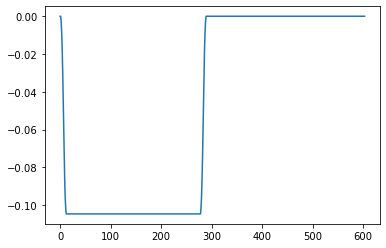

In [ ]:
plt.plot(g_phase_contribution[:,0])

Check k space locations

Text(0.5, 1.0, 'STA phase')

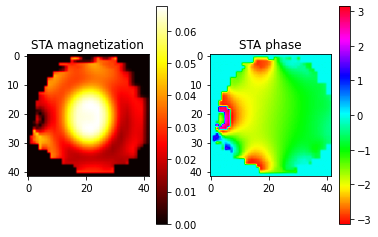

In [ ]:
cha_weights = np.ones(8, dtype=complex) * np.exp(-1j * np.pi / 4 * np.arange(8))
cha_weights = np.concatenate((cha_weights, cha_weights))

sta_mag = np.zeros_like(wmask, dtype=complex)
sta_mag[wmask] = np.matmul(a_mat.T, cha_weights)

fig, ax = plt.subplots(1,2)
im2 = ax[0].imshow(np.abs(sta_mag), cmap='hot')
plt.colorbar(im2, ax=ax[0])
ax[0].set_title('STA magnetization')
im3 = ax[1].imshow(np.angle(sta_mag), cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.colorbar(im3, ax=ax[1])
ax[1].set_title('STA phase')

Target magnetization

In [ ]:
targ_FA = 30  # degrees
targ_magnetization = np.ones_like(wmask) * np.sin(targ_FA * np.pi / 180) 

CLS LSQR

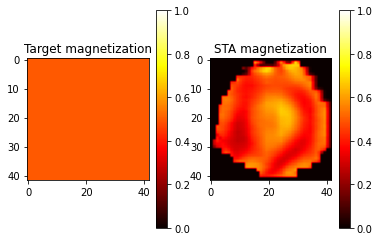

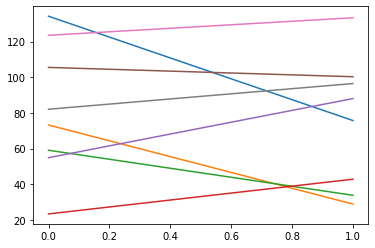

In [ ]:
sol = np.linalg.lstsq(a_mat.T, targ_magnetization[wmask], rcond=None)
# a_mat.T is (nVoxels, DOF), target is (nVoxels,)

sta_mag = np.zeros_like(wmask, dtype=complex)
sta_mag[wmask] = np.matmul(a_mat.T, sol[0])

fig, ax = plt.subplots(1,2)
im1 = ax[0].imshow(targ_magnetization, cmap='hot')
im1.set_clim(0, 1)
plt.colorbar(im1, ax=ax[0])
ax[0].set_title('Target magnetization')

im2 = ax[1].imshow(np.abs(sta_mag), cmap='hot')
im2.set_clim(0, 1)
plt.colorbar(im2, ax=ax[1])
ax[1].set_title('STA magnetization')

fig, ax = plt.subplots()
ax.plot(abs(sol[0]).reshape(-1, b1map.shape[0]))

Add regularizaiton and do CLS again

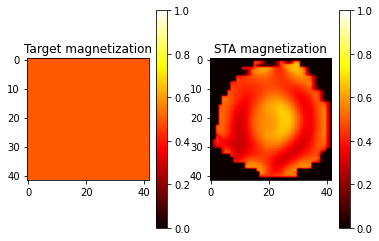

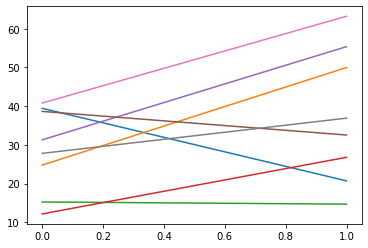

In [ ]:
regularization = 1e-2

astack = np.vstack((a_mat.T, regularization*np.eye(a_mat.shape[0])))
bstack = np.append(targ_magnetization[wmask], np.zeros(a_mat.shape[0]))

sol = np.linalg.lstsq(astack, bstack, rcond=None)
# a_mat.T is (nVoxels, DOF), target is (nVoxels,)

# calculate sta magnetization 
sta_mag = np.zeros_like(wmask, dtype=complex)
sta_mag[wmask] = np.matmul(a_mat.T, sol[0])

fig, ax = plt.subplots(1,2)
im1 = ax[0].imshow(targ_magnetization, cmap='hot')
im1.set_clim(0, 1)
plt.colorbar(im1, ax=ax[0])
ax[0].set_title('Target magnetization')

im2 = ax[1].imshow(np.abs(sta_mag), cmap='hot')
im2.set_clim(0, 1)
plt.colorbar(im2, ax=ax[1])
ax[1].set_title('STA magnetization')

fig, ax = plt.subplots()
ax.plot(abs(sol[0]).reshape(-1, b1map.shape[0]))

Magnitude least squares (MLS)
First do a phase adoption method

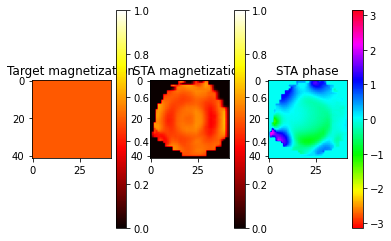

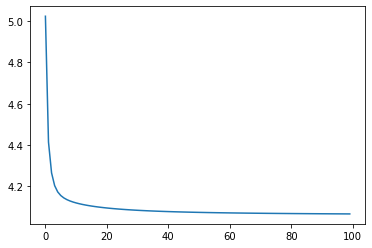

In [ ]:
niter = 100
cost_list = np.zeros(niter)

curr_phase = np.zeros_like(wmask, dtype=complex)
# use all iterations; no stopping criterion
for i in range(niter):
    astack = np.vstack((a_mat.T, regularization*np.eye(a_mat.shape[0])))
    bstack = np.append((targ_magnetization*np.exp(1j*curr_phase))[wmask]
                       , np.zeros(a_mat.shape[0]))
    sol = np.linalg.lstsq(astack, bstack, rcond=None)

    sta_mag = np.zeros_like(wmask, dtype=complex)
    sta_mag[wmask] = np.matmul(a_mat.T, sol[0])
    curr_phase = np.angle(sta_mag)
    cost_list[i] = np.linalg.norm(np.abs(sta_mag[wmask]) - np.abs(targ_magnetization[wmask]))
    
# plot target magnetization and STA magnetization with phase
fig, ax = plt.subplots(1,3)
im1 = ax[0].imshow(targ_magnetization, cmap='hot')
im1.set_clim(0, 1)
plt.colorbar(im1, ax=ax[0])
ax[0].set_title('Target magnetization')

im2 = ax[1].imshow(np.abs(sta_mag), cmap='hot')
im2.set_clim(0, 1)
plt.colorbar(im2, ax=ax[1])
ax[1].set_title('STA magnetization')

im3 = ax[2].imshow(np.angle(sta_mag), cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.colorbar(im3, ax=ax[2])
ax[2].set_title('STA phase')

# plot cost function
fig, ax = plt.subplots()
ax.plot(cost_list)

Try a global optimization

/Users/tzhang/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 508, function evaluations: 16368, CG iterations: 3218, optimality: 1.20e-07, constraint violation: 0.00e+00, execution time:  5.4 s.


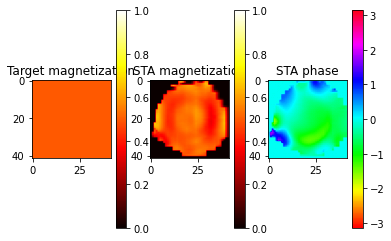

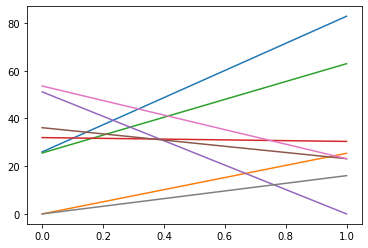

In [ ]:
# define the MLS cost function 
def mls_cost(b_vec: np.ndarray, a_mat: np.ndarray, targ_magnetization: np.ndarray, 
             regularization: float) -> float:
    """
    Arguments:
        b_vec: np.ndarray, (DOF*2,)
        a_mat: np.ndarray, (DOF, nVoxels)
        targ_magnetization: np.ndarray, (nVoxels,)
        regularization: float
    """
    complex_b = b_vec[::2] + 1j*b_vec[1::2]
    sta_mag = np.matmul(a_mat.T, complex_b)
    cost = np.linalg.norm(np.abs(sta_mag) - np.abs(targ_magnetization)) **2 + \
        (regularization * np.linalg.norm(b_vec)) **2
    return cost

bounds = [(0, 200)]*a_mat.shape[0]*2
res = opt.minimize(mls_cost, np.vstack((sol[0].real, sol[0].imag)).T.reshape(-1),
                   bounds=bounds, method='trust-constr', options={'disp': 'iter'},
                   args=(a_mat, targ_magnetization[wmask], regularization))

bopt = res.x[::2] + 1j*res.x[1::2]
sta_mag = np.zeros_like(wmask, dtype=complex)
sta_mag[wmask] = np.matmul(a_mat.T, bopt)

# plot again with optimized magnetization
fig, ax = plt.subplots(1,3)
im1 = ax[0].imshow(targ_magnetization, cmap='hot')
im1.set_clim(0, 1)
plt.colorbar(im1, ax=ax[0])
ax[0].set_title('Target magnetization')
im2 = ax[1].imshow(np.abs(sta_mag), cmap='hot')
im2.set_clim(0, 1)
plt.colorbar(im2, ax=ax[1])
ax[1].set_title('STA magnetization')
im3 = ax[2].imshow(np.angle(sta_mag), cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.colorbar(im3, ax=ax[2])
ax[2].set_title('STA phase')

# plot the coil weights
fig, ax = plt.subplots()
ax.plot(abs(bopt).reshape(-1, b1map.shape[0])) 